In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold

/home/noname/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

Or you can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
```

In [ ]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

In [ ]:
!unzip bank+marketing.zip

In [ ]:
!unzip bank.zip

## Features

For the rest of the homework, you'll need to use only these columns:

* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:
data = pd.read_csv("bank-full.csv", sep=";")
data = data[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]
data.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
## enconde target y to {0, 1}
data.y.apply(lambda x: 1 if x == 'yes' else 0)
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)
data.y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [4]:
data.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [5]:
## Split the data into train val test

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_test

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3610,42,blue-collar,married,primary,2519,yes,unknown,15,may,262,4,-1,0,unknown,0
11677,37,technician,married,secondary,2209,no,unknown,20,jun,167,2,-1,0,unknown,0
33018,32,admin.,married,secondary,923,yes,cellular,17,apr,819,4,-1,0,unknown,0
44323,53,blue-collar,married,primary,306,no,cellular,28,jul,388,3,181,1,success,1
8119,32,technician,single,tertiary,257,yes,unknown,2,jun,183,5,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22959,56,housemaid,married,primary,0,no,cellular,26,aug,102,2,-1,0,unknown,0
26059,33,services,single,secondary,3910,yes,cellular,19,nov,676,2,-1,0,unknown,0
18593,44,unknown,married,unknown,1317,no,telephone,31,jul,444,6,-1,0,unknown,0
6959,31,management,single,tertiary,305,yes,unknown,28,may,297,14,-1,0,unknown,0


In [9]:
y_test = df_test['y']
y_val  = df_val['y']
y_train= df_train['y']

X_test = df_test
del X_test['y']

X_val  = df_val
del X_val['y']

X_train= df_train
del X_train['y']


X_test.head()

KeyError: 'y'

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration` ✅
- `previous`

In [10]:
categorical_vars = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [11]:
## roc score for num vars

print("ROC AUC score of numerical variables:")
for num_var in numerical_vars:
  auc_score = roc_auc_score(y_train, X_train[num_var])
  if auc_score < 0.5:
    auc_score = roc_auc_score(y_train, -X_train[num_var])
  print('%s ==> \t %.3f' % (num_var, auc_score))


ROC AUC score of numerical variables:
age ==> 	 0.512
balance ==> 	 0.589
day ==> 	 0.526
duration ==> 	 0.815
campaign ==> 	 0.571
pdays ==> 	 0.590
previous ==> 	 0.599


# Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89 ✅
- 0.99




In [12]:
dicts_X_train = X_train.to_dict(orient='records')
dicts_X_val = X_val.to_dict(orient='records')


dv_train = DictVectorizer(sparse=False)
X_train = dv_train.fit_transform(dicts_X_train)
X_val = dv_train.transform(dicts_X_val)

In [13]:
## train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
the_score = roc_auc_score(y_val, y_pred)
print(round(the_score, 2))


0.9


# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265 ✅
* 0.465
* 0.665
* 0.865


In [14]:
thresholds = np.arange(0.0, 1.001, 0.01)

scores = []

for th in thresholds:
    real_positive = (y_val == 1)
    real_negative = (y_val == 0)
    
    predicted_positive = (y_pred >= th)
    predicted_negative = (y_pred < th)

    tp = (real_positive & predicted_positive).sum()
    tn = (real_negative & predicted_negative).sum()
    fp = (real_negative & predicted_positive).sum()
    fn = (real_positive & predicted_negative).sum()
    
    scores.append((th, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)



In [15]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,7004,4,940,0.135095,0.996357
2,0.02,1093,5789,5,2155,0.158820,0.995446
3,0.03,1087,4745,11,3199,0.186385,0.989982
4,0.04,1068,3800,30,4144,0.219392,0.972678
...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.638298,0.027322
97,0.97,25,15,1073,7929,0.625000,0.022769
98,0.98,21,10,1077,7934,0.677419,0.019126
99,0.99,11,5,1087,7939,0.687500,0.010018


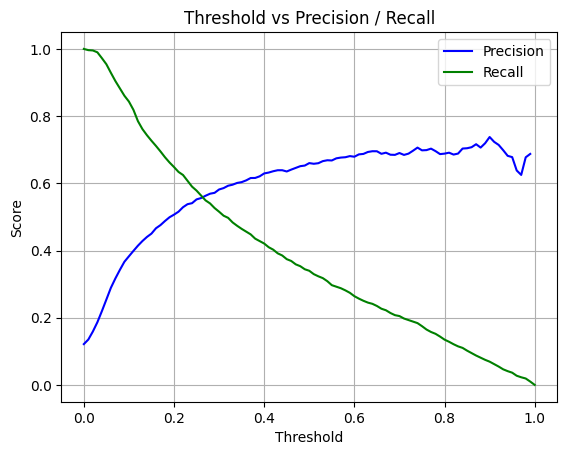

In [16]:
# plot indexes

plt.figure()
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision', color='blue')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision / Recall')
plt.grid()
plt.legend()
plt.show()



In [17]:

df_intersection_region = np.abs(df_scores['precision'] - df_scores['recall'])

df_intersection_region


0      0.878567
1      0.861262
2      0.836626
3      0.803596
4      0.753286
         ...   
96     0.610975
97     0.602231
98     0.658294
99     0.677482
100         NaN
Length: 101, dtype: float64

In [18]:
df_intersection_region.argmin()

26

In [19]:
df_scores.iloc[df_intersection_region.argmin()]

threshold       0.260000
tp            619.000000
fp            494.000000
fn            479.000000
tn           7450.000000
precision       0.556155
recall          0.563752
Name: 26, dtype: float64

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22 ✅
- 0.42
- 0.62


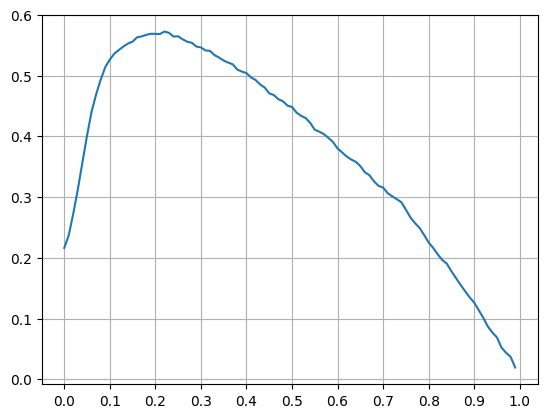

In [20]:
# compute f1
df_scores['f1'] = 2*df_scores.precision*df_scores.recall / (df_scores.precision + df_scores.recall)


# and plot it:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.grid()
plt.show()



In [21]:
df_scores['f1'].argmax()

22

In [22]:
df_scores.iloc[df_scores['f1'].argmax()]

threshold       0.220000
tp            686.000000
fp            611.000000
fn            412.000000
tn           7333.000000
precision       0.528913
recall          0.624772
f1              0.572860
Name: 22, dtype: float64

# Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006 ✅
- 0.06
- 0.26

 

In [23]:
def train_model(df_original, y, C=1.0):
    data = df_original[numerical_vars + categorical_vars].to_dict(orient='records')
    
    dv_dict = DictVectorizer(sparse=False)
    dv_dict.fit(data)

    X = dv_dict.transform(data)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv_dict, model


def predict(df_original, dv_dict, model):
    data = df_original[numerical_vars + categorical_vars].to_dict(orient='records')
    
    X = dv_dict.transform(data)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
roc_auc_scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y
    y_val = df_val.y

    dv, model = train_model(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_scores.append(roc_auc)

print('The mean of ROC AUC scores is %f, with a SD of %f' % (np.mean(roc_auc_scores), np.std(roc_auc_scores)))

The mean of ROC AUC scores is 0.905865, with a SD of 0.005653


# Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1 ✅

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for c in [0.000001, 0.001, 1]:
    roc_auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train_model(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        roc_auc_scores.append(auc)

    print('C=%s, mean: %f, SD: %f' % (c, np.mean(roc_auc_scores), np.std(roc_auc_scores)))

C=1e-06, mean: 0.701445, SD: 0.009444
C=0.001, mean: 0.860843, SD: 0.007180
C=1, mean: 0.905865, SD: 0.005653
